# 04b Multiple Linear regression model trained on good IMD regions 

> k-fold cross validation of regression model choice   

In [1]:
#|default_exp core.04_regression_model

In [2]:
#|hide
import nbdev; nbdev.nbdev_export()

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/nbdev/export.py:73: UserWarning: Notebook '/Users/bea/adu_dev/dementia_inequalities/nbs/core/03a_explore_datasets.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"


In [3]:
#|hide
from nbdev.showdoc import show_doc

In [4]:
#|export
import dementia_inequalities as proj
from dementia_inequalities import const, log, utils, tools
import adu_proj.utils as adutils

In [5]:
#|export
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_score
import itertools

import scipy.stats as st

### Load the Autonomy style bits 

In [6]:
# Define the font path and style path
FONT_PATH = const.raw_data_path + '/JosefinSans-Regular.ttf'
STYLEPATH = const.raw_data_path + '/autonomy_white.mplstyle'

# Add the font to the font manager
fm.fontManager.addfont(FONT_PATH)

# Set the font family for matplotlib to use
plt.rcParams['font.family'] = 'Josefin Sans'
plt.style.use(STYLEPATH)

# Inform the user that the font was set
print("Josefin Sans font set for Matplotlib.")
print("mplstyle activated.")

Josefin Sans font set for Matplotlib.
mplstyle activated.


---

This model looks at automating the choice of parameters and the choice of training dataset using k-fold cross validation. 

In [7]:
#|export 
df_dem_plus = pd.read_csv(const.output_path+'/df_dem_plus.csv')

In [8]:
df_dem_plus.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,93.2,1.054537,41.277676,29.459719,51.924546,16.393357,5.298762,2.534370,186.084815,0.105584
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,63.0,0.520773,57.864140,16.212434,51.872532,8.334167,2.933158,1.034842,437.450820,0.224167
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,84.2,0.757572,45.298420,19.513040,51.475795,11.160066,3.982729,1.633168,124.734713,0.107840
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,87.8,0.864371,46.247977,20.734161,51.097420,11.826167,4.774197,1.863024,442.084950,0.311082
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,93.8,0.658556,39.900936,24.100070,51.143136,13.049211,5.147664,1.839612,78.032656,0.093811


These are the covariates I'm interested in - each is calculated as a percentage of the total population of the region. 
* Age (% people over 65) `over_65_pc`
* Gender (% people female) `female_pc`
* Educational attainment (% people with A-level or higher education) `ALevel_plus_pc`
* Ethnicity (% people who are white British) `white_pc`
* Comorbidities (% people with various dementia comorbidities)
    - Hypertension `HYP_afflicted_pc`
    - Diabetes `DM_afflicted_pc`
    - Stroke `STIA_afflicted_pc`
* Density of GPs (total number of GPs/ pop) `GP_LAD_pc`

In [9]:
# Potential covariates 
covar_opt = ['over_65_pc', 
             'female_pc', 
             'ALevel_plus_pc', 
             'white_pc', 
             'HYP_afflicted_pc', 
             'DM_afflicted_pc', 
             'STIA_afflicted_pc', 
             'GP_LAD_pc']

covar_opt_noGP = ['over_65_pc', 
             'female_pc', 
             'ALevel_plus_pc', 
             'white_pc', 
             'HYP_afflicted_pc', 
             'DM_afflicted_pc', 
             'STIA_afflicted_pc']

covar_opt_no_comor  = ['over_65_pc', 
             'female_pc', 
             'ALevel_plus_pc', 
             'white_pc']


How do we understand these residuals? Might be a good idea to look at the areas which we would expect to have high rates of diagnosis - for example if we look at top 50 areas accoridng to the IMD (or ADI). 

In [10]:
df_IMD = pd.read_excel(const.data_path+'/IoD2019_Local_Authority_District_Summaries__lower-tier__.xlsx', sheet_name='IMD')

In [11]:
# the 50 least deprived LADs according to the IMD
least_50_IMD = list(df_IMD[df_IMD['IMD - Rank of average rank ']>317-55]['Local Authority District name (2019)'])

# check the overlap between regions in IMD and ADI 
df_dem_topIMD = df_dem_plus[df_dem_plus['area_name'].isin(least_50_IMD)].copy()

list_45 = list(df_dem_topIMD['area_name'])
list(set(least_50_IMD).difference(list_45))

['Wycombe',
 'South Bucks',
 'Aylesbury Vale',
 'South Northamptonshire',
 'Chiltern']

In [12]:
len(df_dem_topIMD)

50

In [13]:
print(least_50_IMD)

['York', 'Rutland', 'Bath and North East Somerset', 'South Gloucestershire', 'Bracknell Forest', 'West Berkshire', 'Windsor and Maidenhead', 'Wokingham', 'Central Bedfordshire', 'Aylesbury Vale', 'Chiltern', 'South Bucks', 'Wycombe', 'East Cambridgeshire', 'South Cambridgeshire', 'Derbyshire Dales', 'Brentwood', 'Rochford', 'Uttlesford', 'Cotswold', 'Stroud', 'East Hampshire', 'Eastleigh', 'Fareham', 'Hart', 'Winchester', 'North Hertfordshire', 'Three Rivers', 'Tunbridge Wells', 'Ribble Valley', 'Blaby', 'Harborough', 'North Kesteven', 'South Northamptonshire', 'Harrogate', 'Rushcliffe', 'South Oxfordshire', 'Vale of White Horse', 'West Oxfordshire', 'Elmbridge', 'Epsom and Ewell', 'Guildford', 'Mole Valley', 'Reigate and Banstead', 'Surrey Heath', 'Waverley', 'Woking', 'Warwick', 'Horsham', 'Mid Sussex', 'Bromsgrove', 'St Albans', 'East Hertfordshire', 'Kingston upon Thames', 'Richmond upon Thames']


2020, the former District Council areas of Aylesbury Vale, Chiltern, South Bucks and Wycombe and Buckinghamshire County Council came together to form a single Unitary Authority, Buckinghamshire Council.

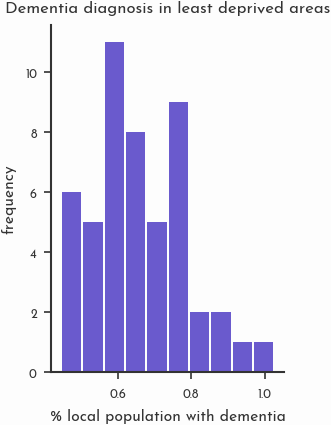

In [14]:
# dementia diagnosis in least deprived areas 
dem_diag_least_IMD = df_dem_topIMD['DEM_afflicted_pc']

# histogram plot of frequency of diagnosis % 
plt.hist(dem_diag_least_IMD, color='slateblue', rwidth=0.9)
plt.title('Dementia diagnosis in least deprived areas')
plt.xlabel('% local population with dementia')
plt.ylabel('frequency')
plt.show()

## All possible covariates 
What happens if I include all possible covariates?

In [15]:
print(covar_opt)

['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc']


In [16]:
# Linear regression using sklearn 

x_IMD_train = df_dem_topIMD[covar_opt].values.reshape(-1,len(covar_opt))
y_IMD_train = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all = df_dem_plus[covar_opt].values.reshape(-1,len(covar_opt))
y_test_all = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

regr = linear_model.LinearRegression()

# fit regression comorbidities
regr.fit(x_IMD_train, y_IMD_train)
y_pred_all = regr.predict(x_test_all)

In [17]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(covar_opt):
    print(f'{covar}:{regr.coef_[0][i]} \n')

intercept:-1.8469778556729306
-------- 
 coefficients of independent variables 
 
over_65_pc:0.014270387122860363 

female_pc:0.04855291227400002 

ALevel_plus_pc:-0.0071512139230152875 

white_pc:-0.004578392253143034 

HYP_afflicted_pc:0.035602981549377355 

DM_afflicted_pc:-0.061638105147520904 

STIA_afflicted_pc:0.19981679641867864 

GP_LAD_pc:-0.04347317523992019 



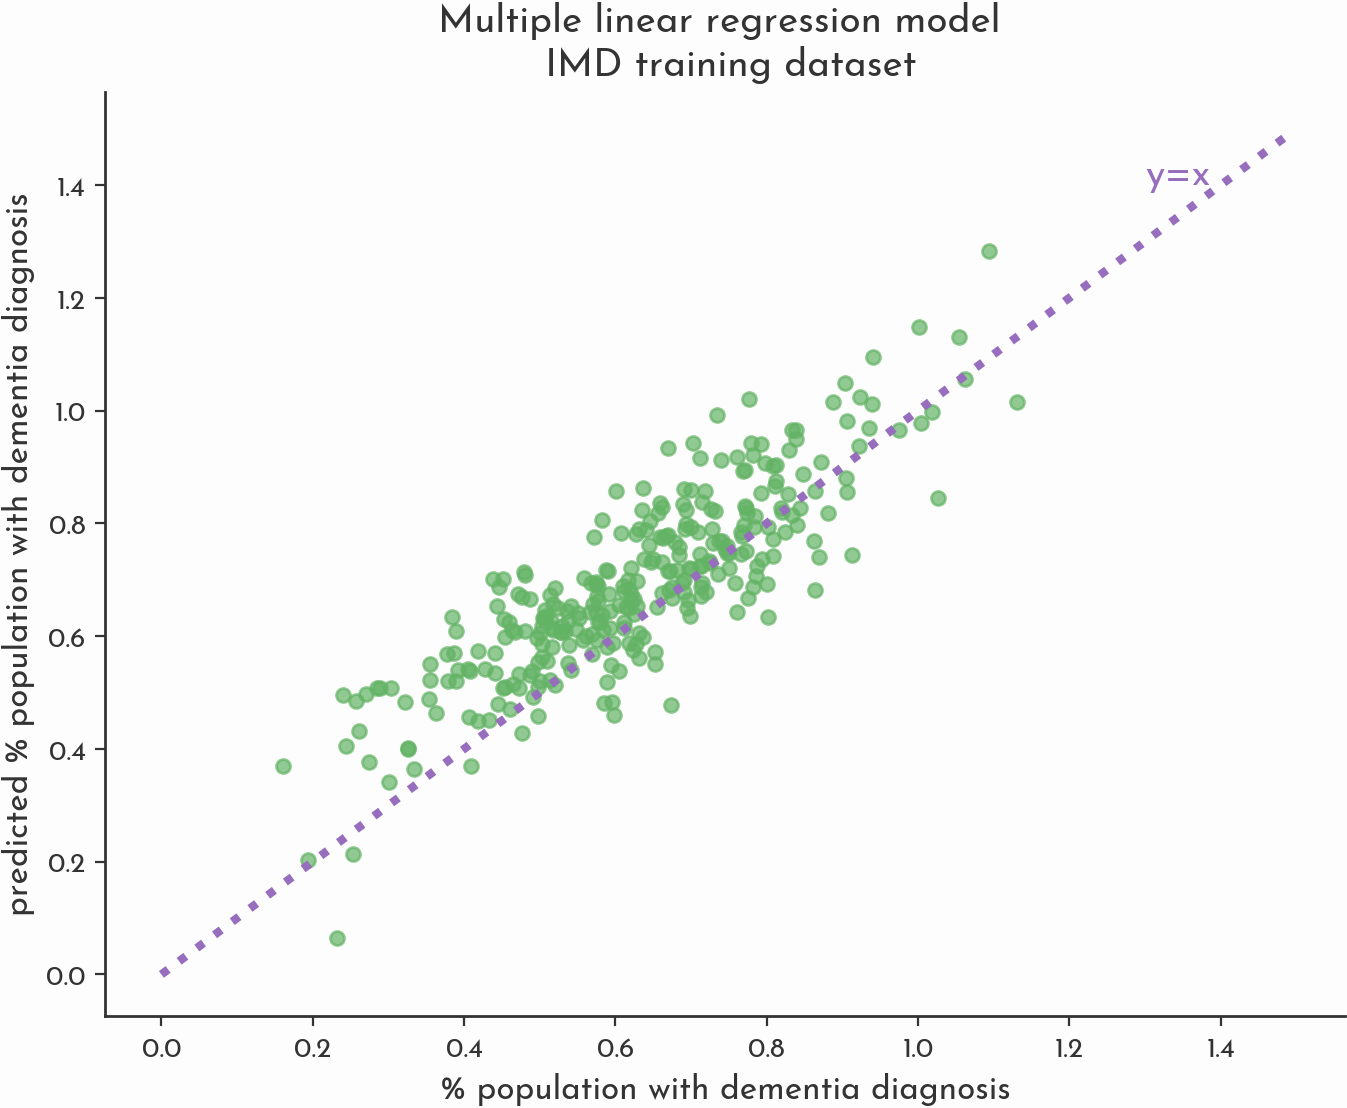

In [18]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 

plt.figure(figsize=(8,6), dpi=200)
plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='xkcd:deep lilac')
plt.scatter(y_test_all, y_pred_all, color='xkcd:boring green', alpha=0.7)
plt.xlabel('% population with dementia diagnosis', fontsize=12)
plt.ylabel('predicted % population with dementia diagnosis', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Multiple linear regression model \n IMD training dataset', fontsize=14)
plt.text(1.3, 1.4, r'y=x', fontsize=14, color='xkcd:deep lilac')
plt.savefig(const.figs_path+'/IMD_linear_reg_scatter_plt.png')
plt.show()

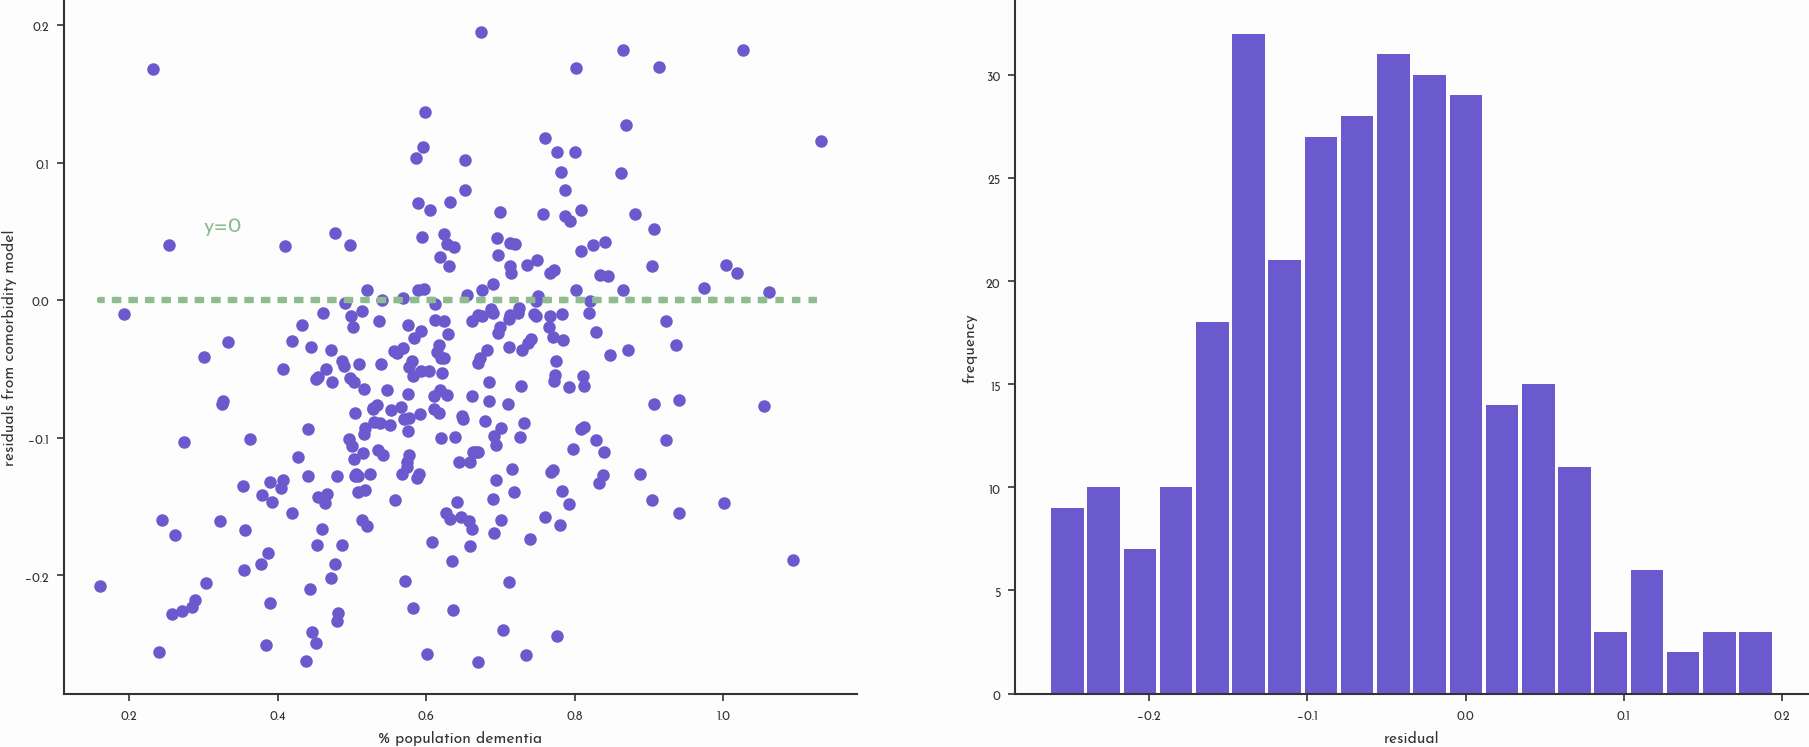

In [19]:
plt.subplots(nrows=1, ncols= 2, figsize = (15,6))

residuals = (y_test_all-y_pred_all)
 
# look at the residuals 
plt.subplot(1, 2, 1)
plt.scatter(y_test_all, residuals, color='slateblue')
plt.plot(y_test_all, np.zeros(len(y_test_all)), ':', color='darkseagreen')
plt.text(0.3, 0.05, r'y=0', fontsize=10, color='darkseagreen')
plt.ylabel('residuals from comorbidity model')
plt.xlabel('% population dementia')

# histogram plot of the models residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, color='slateblue', rwidth=0.9, bins=20)
plt.xlabel('residual')
plt.ylabel('frequency')
plt.show()

### Same again, but leaving out the GP density covariate 

In [20]:
# Linear regression using sklearn 

x_IMD_train_noGP = df_dem_topIMD[covar_opt_noGP].values.reshape(-1,len(covar_opt_noGP))
y_IMD_train = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all_noGP = df_dem_plus[covar_opt_noGP].values.reshape(-1,len(covar_opt_noGP))
y_test_all = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

regr_noGP = linear_model.LinearRegression()

# fit regression comorbidities
regr_noGP.fit(x_IMD_train_noGP, y_IMD_train)
y_pred_all_noGP = regr_noGP.predict(x_test_all_noGP)

print(f'intercept:{regr_noGP.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(covar_opt_noGP):
    print(f'{covar}:{regr_noGP.coef_[0][i]} \n')

intercept:-1.880192036571768
-------- 
 coefficients of independent variables 
 
over_65_pc:0.01365609374316959 

female_pc:0.04901368654316657 

ALevel_plus_pc:-0.007166798504024146 

white_pc:-0.004540669206969925 

HYP_afflicted_pc:0.036687315455347085 

DM_afflicted_pc:-0.06318903970112894 

STIA_afflicted_pc:0.20494263127130188 



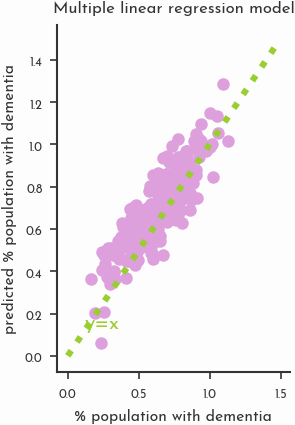

In [21]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 

plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='yellowgreen')
plt.scatter(y_test_all, y_pred_all_noGP, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(0.12, 0.13, r'y=x', fontsize=10, color='yellowgreen')
#plt.text(0.2, 0.12, r'potential underdiagnosis', fontsize=10)
plt.show()

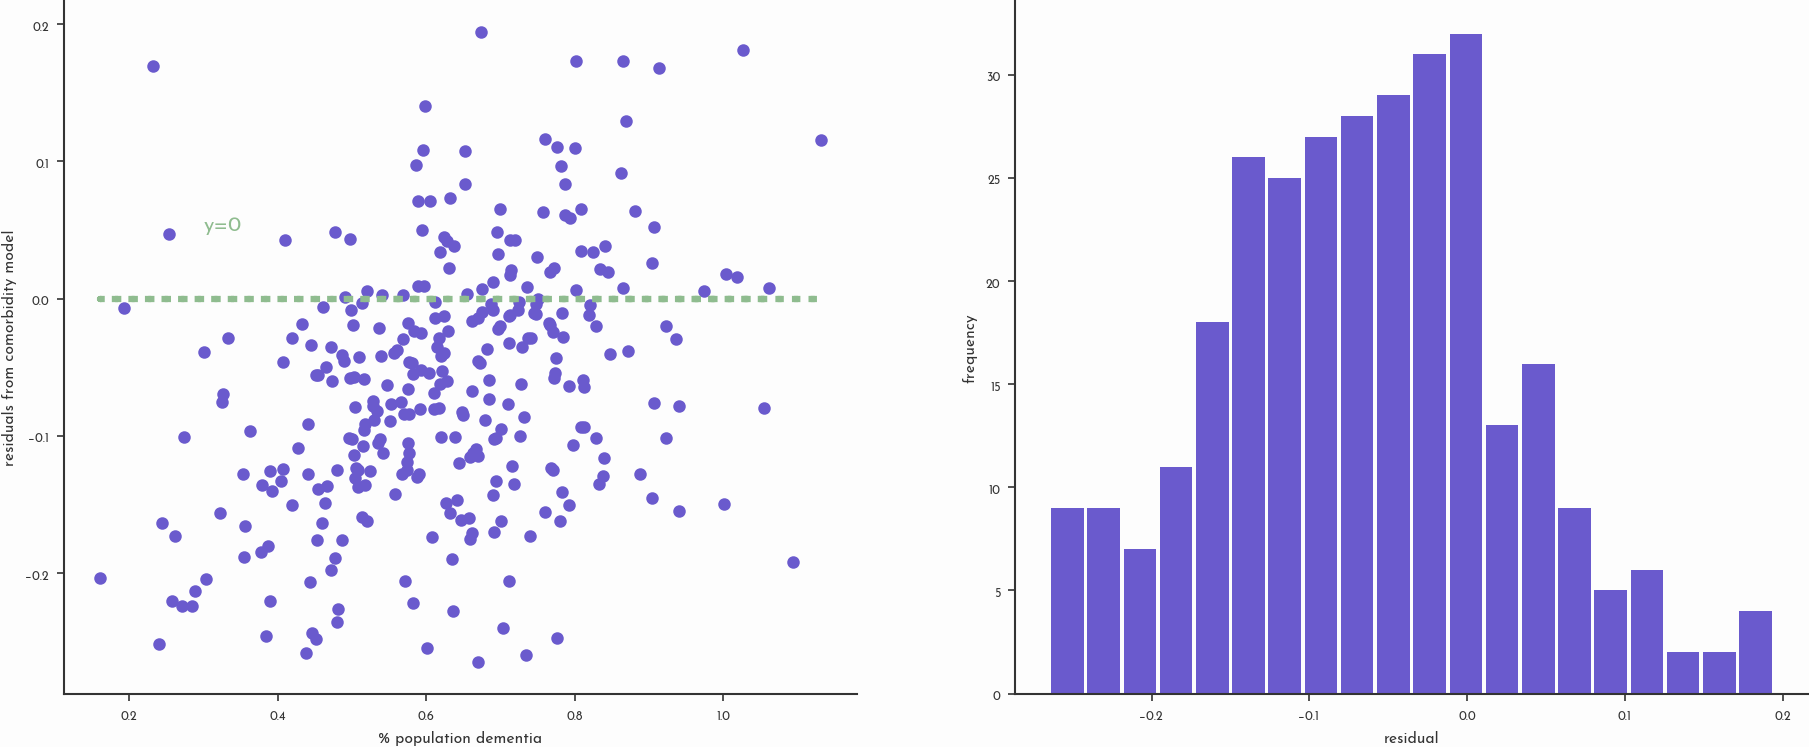

In [22]:
plt.subplots(nrows=1, ncols= 2, figsize = (15,6))

residuals_noGP = (y_test_all-y_pred_all_noGP)
 
# look at the residuals 
plt.subplot(1, 2, 1)
plt.scatter(y_test_all, residuals_noGP, color='slateblue')
plt.plot(y_test_all, np.zeros(len(y_test_all)), ':', color='darkseagreen')
plt.text(0.3, 0.05, r'y=0', fontsize=10, color='darkseagreen')
plt.ylabel('residuals from comorbidity model')
plt.xlabel('% population dementia')

# histogram plot of the models residuals
plt.subplot(1, 2, 2)
plt.hist(residuals_noGP, color='slateblue', rwidth=0.9, bins=20)
plt.xlabel('residual')
plt.ylabel('frequency')
plt.show()

### Same again, but leaving out the comorbidities and GP density  

In [23]:
# Linear regression using sklearn 

x_IMD_train_no_comor = df_dem_topIMD[covar_opt_no_comor].values.reshape(-1,len(covar_opt_no_comor))
y_IMD_train = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all_no_comor = df_dem_plus[covar_opt_no_comor].values.reshape(-1,len(covar_opt_no_comor))
y_test_all = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

regr_no_comor = linear_model.LinearRegression()

# fit regression comorbidities
regr_no_comor.fit(x_IMD_train_no_comor, y_IMD_train)
y_pred_all_no_comor = regr_no_comor.predict(x_test_all_no_comor)

print(f'intercept:{regr_no_comor.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(covar_opt_no_comor):
    print(f'{covar}:{regr_no_comor.coef_[0][i]} \n')

intercept:-1.7811754201707677
-------- 
 coefficients of independent variables 
 
over_65_pc:0.03558690497636593 

female_pc:0.04154508643489294 

ALevel_plus_pc:-0.006226343468360972 

white_pc:-0.0014626597590438463 



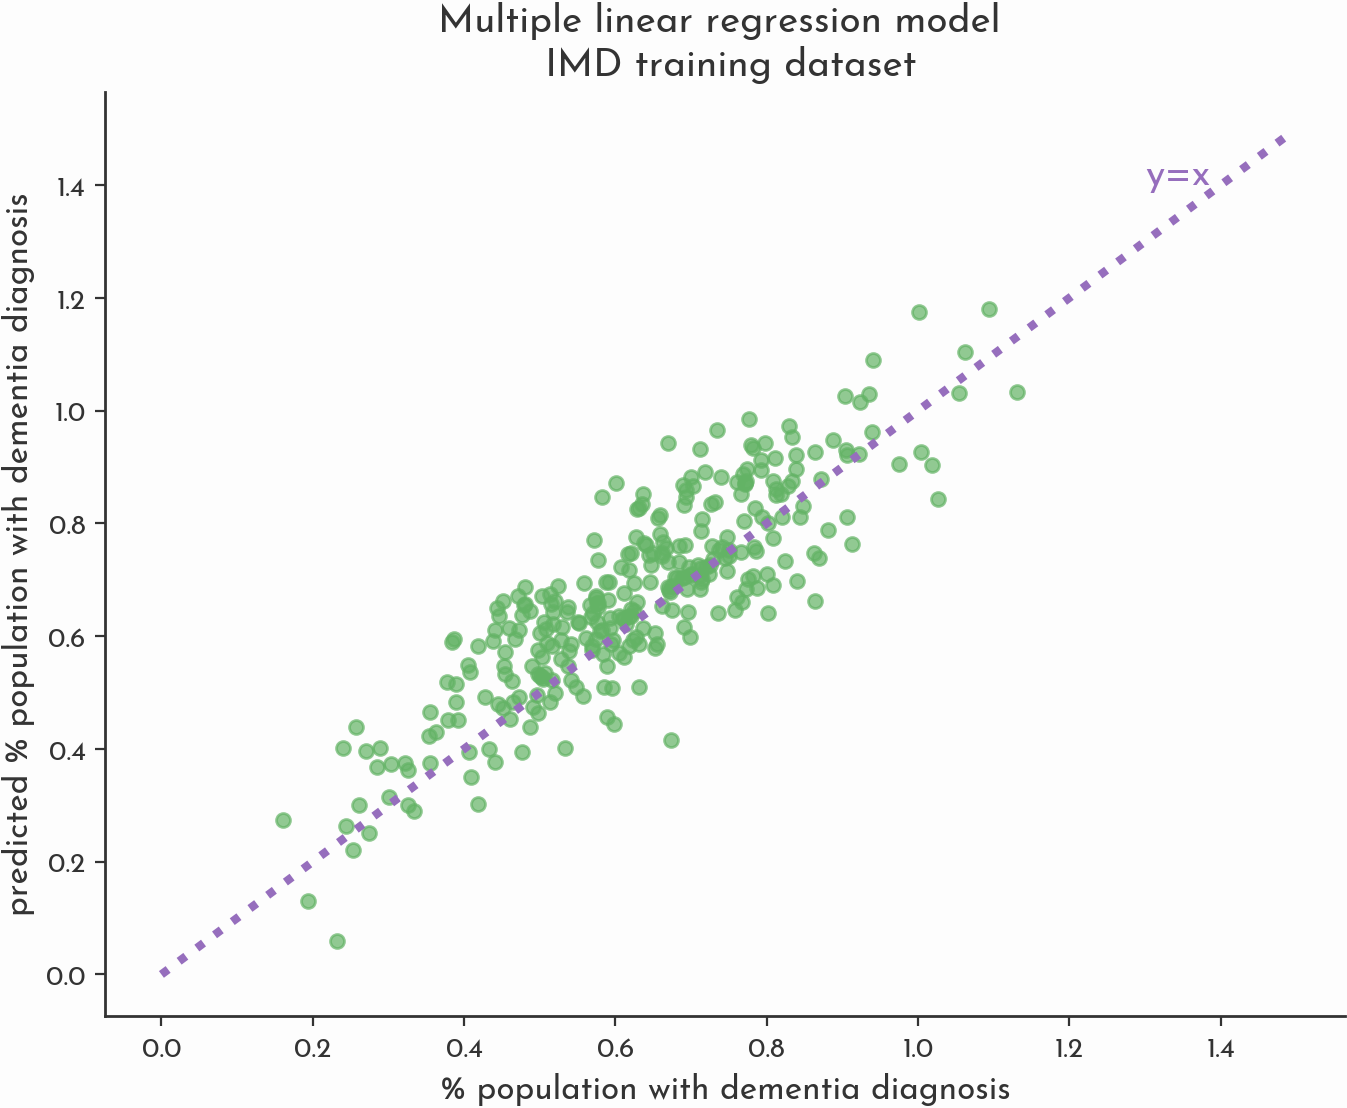

In [24]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 

plt.figure(figsize=(8,6), dpi=200)
plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='xkcd:deep lilac')
plt.scatter(y_test_all, y_pred_all_no_comor, color='xkcd:boring green', alpha=0.7)
plt.xlabel('% population with dementia diagnosis', fontsize=12)
plt.ylabel('predicted % population with dementia diagnosis', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Multiple linear regression model \n IMD training dataset', fontsize=14)
plt.text(1.3, 1.4, r'y=x', fontsize=14, color='xkcd:deep lilac')
plt.savefig(const.figs_path+'/IMD_linear_reg_scatter_plt.png')
plt.show()

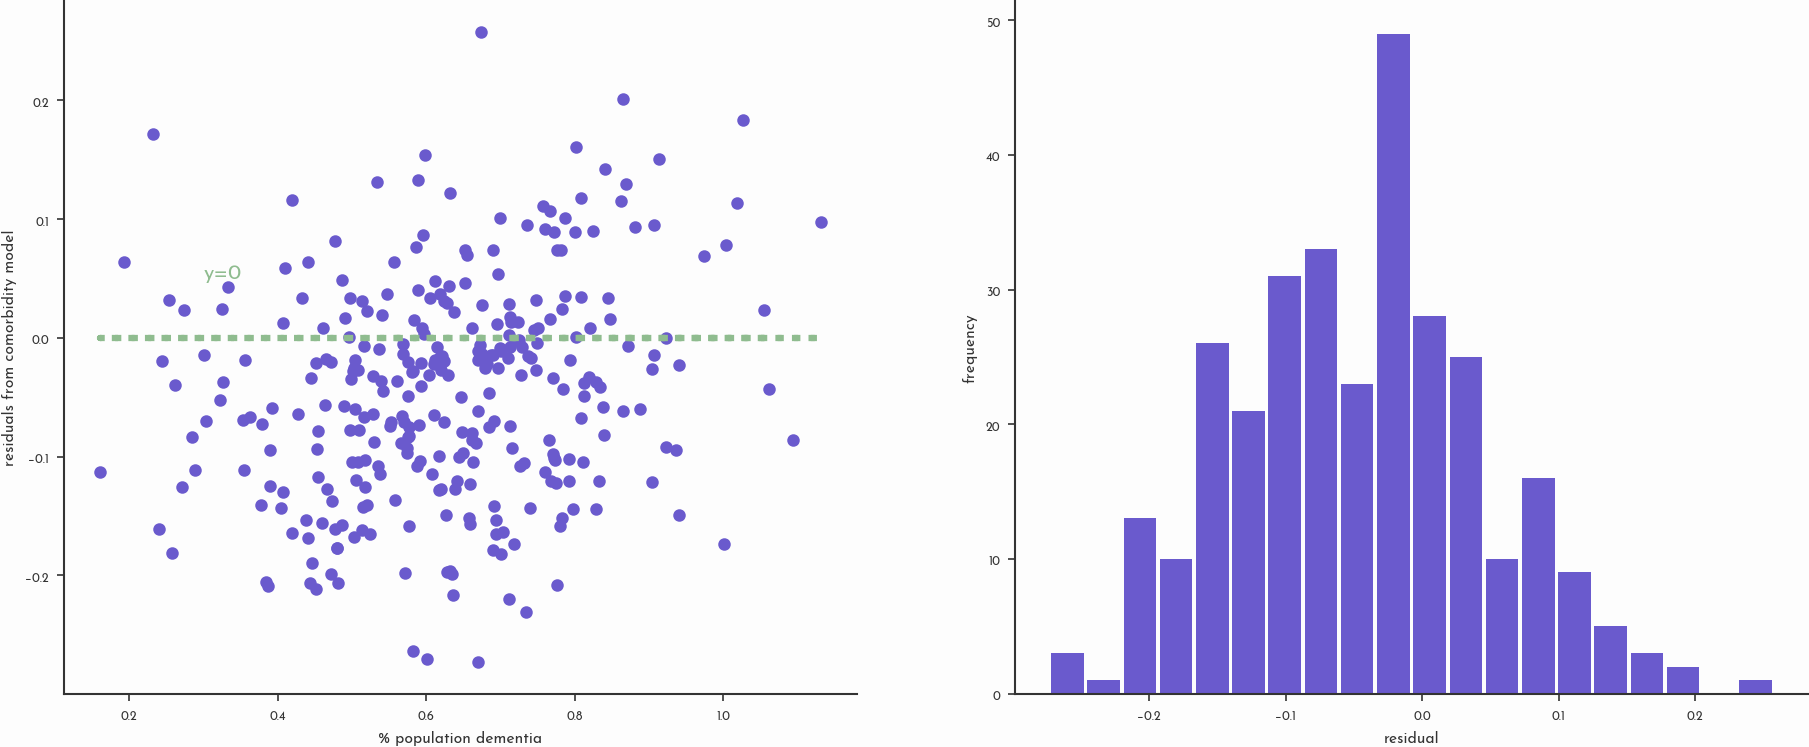

In [25]:
plt.subplots(nrows=1, ncols= 2, figsize = (15,6))

residuals_no_comor = (y_test_all-y_pred_all_no_comor)
 
# look at the residuals 
plt.subplot(1, 2, 1)
plt.scatter(y_test_all, residuals_no_comor, color='slateblue')
plt.plot(y_test_all, np.zeros(len(y_test_all)), ':', color='darkseagreen')
plt.text(0.3, 0.05, r'y=0', fontsize=10, color='darkseagreen')
plt.ylabel('residuals from comorbidity model')
plt.xlabel('% population dementia')

# histogram plot of the models residuals
plt.subplot(1, 2, 2)
plt.hist(residuals_no_comor, color='slateblue', rwidth=0.9, bins=20)
plt.xlabel('residual')
plt.ylabel('frequency')
plt.show()

### Save the results of the regression model to a .csv 

In [26]:
# add columns of results to the dataframe 
df_dem_plus['IMD_reg_model_residuals'] = residuals
df_dem_plus['IMD_reg_model_pred'] = y_pred_all

df_dem_plus['IMD_reg_model_noGP_residuals'] = residuals_noGP
df_dem_plus['IMD_reg_model_noGP_pred'] = y_pred_all_noGP

df_dem_plus['IMD_reg_model_nocomor_residuals'] = residuals_no_comor
df_dem_plus['IMD_reg_model_nocomor_pred'] = y_pred_all_no_comor

# save the dataframe 
df_dem_plus.to_csv(const.output_path+'/test_set_reg_model/IMD_reg_model_results.csv')

## Look at IMD rank of areas with large residuals

In [27]:
# Areas residuals 

# look at areas with gap between predicted diagnosis rate and observed diagnosis rate 
resid_gap_area = df_dem_plus[residuals<-0.3]['area_name']
print(resid_gap_area)
#[x for x in list(resid_gap_area)]

Series([], Name: area_name, dtype: object)


In [28]:
residuals[40]

array([-0.2632623])

In [29]:
df_dem_plus[df_dem_plus['area_name']=='South Hams']

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc,IMD_reg_model_residuals,IMD_reg_model_pred,IMD_reg_model_noGP_residuals,IMD_reg_model_noGP_pred,IMD_reg_model_nocomor_residuals,IMD_reg_model_nocomor_pred
40,E07000044,South Hams,74072,597.62437,12201.179619,4036.440908,1928.689732,42560.0,46217.5554,42993.9842,...,4.524573,2.161929,133.272272,0.149389,-0.263262,0.933158,-0.264741,0.934637,-0.273092,0.942988


In [30]:
worst_5_resid = np.argsort(np.array(residuals.reshape(309)))[-15:]
df_dem_plus.iloc[worst_5_resid, :][['area_name']+covar_opt]

,area_name,over_65_pc,female_pc,ALevel_plus_pc,white_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_LAD_pc
295,Cheltenham,19.400724,51.115546,49.094168,83.3,9.063336,3.490792,1.327792,0.048001
191,Woking,16.657886,50.331709,47.417765,67.3,9.025650,3.752558,1.101290,0.353303
138,Ashfield,19.789999,51.073897,32.102029,91.8,12.447001,5.849559,1.740841,0.080665
183,Waverley,21.861401,51.551098,49.761982,86.8,11.045392,3.515780,1.404394,0.094951
248,Guildford,17.610517,50.682072,52.928160,77.3,10.228397,3.689333,1.125962,0.248244
29,East Devon,29.988670,51.756004,42.618083,94.2,15.053160,5.553345,2.346675,0.116072
159,Rushcliffe,21.727135,51.032720,50.974377,86.1,10.958432,3.975366,1.617780,0.176461
272,Gosport,21.484777,50.990447,36.468339,92.5,14.221484,6.352696,1.891783,0.061739
289,Lincoln,14.808616,50.408451,44.181462,82.7,9.340654,3.876114,1.263081,0.058509
283,City of London,14.319242,45.115713,77.168613,42.5,8.398349,3.304119,0.889356,0.242660


In [31]:
df_IMD[df_IMD['Local Authority District name (2019)'].isin(resid_gap_area)]

,Local Authority District code (2019),Local Authority District name (2019),IMD - Average rank,IMD - Rank of average rank,IMD - Average score,IMD - Rank of average score,IMD - Proportion of LSOAs in most deprived 10% nationally,IMD - Rank of proportion of LSOAs in most deprived 10% nationally,IMD 2019 - Extent,IMD 2019 - Rank of extent,IMD 2019 - Local concentration,IMD 2019 - Rank of local concentration


In [32]:
df_dem_plus_IMD = pd.merge(df_dem_plus, df_IMD[['IMD - Rank of average rank ', 'Local Authority District name (2019)']], left_on='area_name', right_on='Local Authority District name (2019)')

In [33]:
df_dem_plus_IMD.drop(columns='Local Authority District name (2019)', inplace=True)

In [34]:
df_dem_plus_IMD

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc,IMD_reg_model_residuals,IMD_reg_model_pred,IMD_reg_model_noGP_residuals,IMD_reg_model_noGP_pred,IMD_reg_model_nocomor_residuals,IMD_reg_model_nocomor_pred,IMD - Rank of average rank
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,2.534370,186.084815,0.105584,-0.076949,1.131486,-0.079575,1.134112,0.023451,1.031086,241
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,1.034842,437.450820,0.224167,0.007108,0.513665,0.005367,0.515406,0.022379,0.498394,297
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,1.633168,124.734713,0.107840,0.062741,0.694831,0.062769,0.694803,0.110972,0.646600,273
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,1.863024,442.084950,0.311082,0.181734,0.682637,0.173057,0.691314,0.201213,0.663159,112
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,1.839612,78.032656,0.093811,-0.117544,0.776100,-0.115681,0.774237,-0.157027,0.815583,162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,E07000098,Hertsmere,82921,670.292640,11021.724346,4685.682668,1328.437922,46875.0,56088.1445,51979.7732,...,1.229262,184.238057,0.170484,-0.042335,0.662586,-0.041825,0.662076,-0.027444,0.647695,224
302,E08000024,Sunderland,228781,1815.593270,39805.733965,15607.611455,5391.466952,94211.0,141179.1277,133107.8801,...,1.965630,392.005902,0.142918,-0.166381,0.828313,-0.170368,0.832300,-0.080357,0.742289,33
303,E06000050,Cheshire West and Chester,281913,2115.072286,42946.758704,16327.686339,5778.511168,157848.0,182966.3133,174617.3565,...,1.615989,262.879898,0.073516,-0.082949,0.674440,-0.080379,0.671869,-0.104083,0.695573,183
304,E07000210,Mole Valley,72165,707.782207,10694.196102,3455.860767,1495.801962,42396.0,44954.5255,42642.7851,...,1.707589,136.391104,0.155702,0.035593,0.772402,0.034703,0.773292,0.034352,0.773644,294


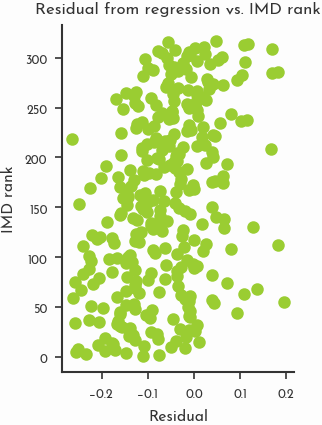

In [35]:
plt.scatter(df_dem_plus_IMD['IMD_reg_model_residuals'], df_dem_plus_IMD['IMD - Rank of average rank '], color='yellowgreen')
plt.xlabel('Residual')
plt.ylabel('IMD rank')
plt.title('Residual from regression vs. IMD rank')
plt.show()

### Ridge regression 

In [36]:
# Alternative linear regression using sklearn 

x_all_covar = df_dem_topIMD[covar_opt].values.reshape(-1,8)
y = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all_covar = df_dem_plus[covar_opt].values.reshape(-1,8)

regr = linear_model.Ridge(alpha=1)

# fit regression comorbidities
regr.fit(x_all_covar, y)
y_pred_all = regr.predict(x_test_all_covar)

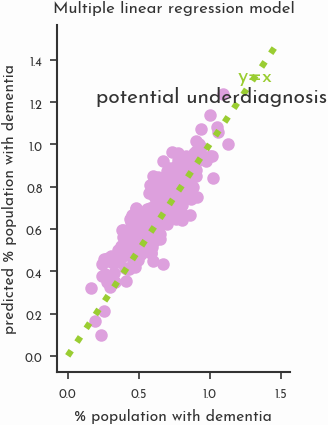

In [37]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 
true_val = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='yellowgreen')
plt.scatter(true_val, y_pred_all, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(1.2, 1.3, r'y=x', fontsize=10, color='yellowgreen')
plt.text(0.2, 1.2, r'potential underdiagnosis', fontsize=10)
plt.show()

In [38]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(covar_opt):
    print(f'{covar}:{regr.coef_[0][i]} \n')

intercept:-2.0173606857124127
-------- 
 coefficients of independent variables 
 
over_65_pc:0.01963706209459835 

female_pc:0.046636786164010166 

ALevel_plus_pc:-0.0049883580307704565 

white_pc:-0.0029022331232526743 

HYP_afflicted_pc:0.03635197053099309 

DM_afflicted_pc:-0.037606030744696366 

STIA_afflicted_pc:0.07087087494383967 

GP_LAD_pc:-0.01591042680734476 



In [39]:
np.dot(np.array(x_test_all_covar), regr.coef_[0]) + regr.intercept_[0]

array([1.08093815, 0.51111686, 0.66609504, 0.66474977, 0.7794394 ,
       0.48041589, 0.6017189 , 0.68028797, 0.78907916, 0.57364998,
       0.71561652, 0.66630538, 0.63942806, 0.92240003, 0.7650685 ,
       0.68886142, 0.84125913, 0.55307216, 0.64251787, 0.6996531 ,
       0.44899265, 0.43483799, 0.76140293, 0.72605944, 0.92397014,
       0.79989103, 0.60356569, 0.73331119, 0.74038535, 1.00211469,
       0.69687641, 0.9675761 , 0.56281717, 0.85245903, 0.57787106,
       0.94347997, 0.72649776, 0.5948206 , 0.92395251, 0.57222015,
       0.92071939, 0.34793303, 0.49036828, 0.51016865, 0.69766429,
       0.69286513, 0.50890387, 0.75656499, 0.34840687, 0.77472378,
       0.76157325, 0.44382101, 0.56239344, 0.53676995, 0.60685322,
       0.70551221, 1.0026055 , 0.62682212, 0.48199328, 0.84907945,
       0.57348833, 0.92481917, 0.16528374, 0.94438778, 0.60411783,
       0.51975485, 0.75171221, 0.56958877, 0.62967159, 0.53403994,
       0.56878364, 0.8984574 , 0.73029019, 0.44822828, 1.01708

### Lasso regression 

In [40]:
# Alternative linear regression using sklearn 

x_all_covar = df_dem_topIMD[covar_opt].values.reshape(-1,8)
y = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all_covar = df_dem_plus[covar_opt].values.reshape(-1,8)

regr = linear_model.Lasso(alpha=0.001)

# fit regression comorbidities
regr.fit(x_all_covar, y)
y_pred_all = regr.predict(x_test_all_covar)

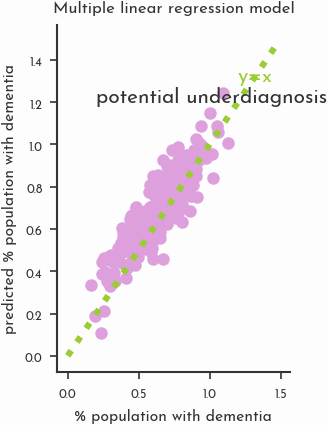

In [41]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 
true_val = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='yellowgreen')
plt.scatter(true_val, y_pred_all, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(1.2, 1.3, r'y=x', fontsize=10, color='yellowgreen')
plt.text(0.2, 1.2, r'potential underdiagnosis', fontsize=10)
plt.show()

In [42]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(covar_opt):
    print(f'{covar}:{regr.coef_[i]} \n')

intercept:-1.8785399069558282
-------- 
 coefficients of independent variables 
 
over_65_pc:0.017990235516920826 

female_pc:0.04441308877384491 

ALevel_plus_pc:-0.005195568919043534 

white_pc:-0.0029179667887760143 

HYP_afflicted_pc:0.030445932387454112 

DM_afflicted_pc:-0.03300910050105176 

STIA_afflicted_pc:0.11511216212196693 

GP_LAD_pc:-0.0 



## Alternative using the GP density to select the training set 

In [43]:
# the 50 least deprived LADs according to the IMD
GP_vals = df_dem_plus['GP_LAD_pc'].values

df_highest_GP_50 = df_dem_plus.iloc[GP_vals.argsort()[-50:]]

# let's check this dataset 
df_highest_GP_50.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc,IMD_reg_model_residuals,IMD_reg_model_pred,IMD_reg_model_noGP_residuals,IMD_reg_model_noGP_pred,IMD_reg_model_nocomor_residuals,IMD_reg_model_nocomor_pred
253,E07000066,Basildon,147650,836.308895,21230.763939,8435.195025,2707.627275,61857.0,96431.9056,91197.3989,...,4.495670,1.443073,312.348745,0.166471,-0.241217,0.686941,-0.243724,0.689448,-0.189748,0.635472
282,E06000034,Thurrock,134300,886.532257,19070.911233,7859.279298,2118.297546,57874.0,89792.8781,86056.9890,...,4.469312,1.204606,293.921392,0.167143,-0.128108,0.632250,-0.130308,0.634450,-0.019067,0.523209
225,E06000045,Southampton,205834,1664.001173,22723.123526,10561.641413,3355.664732,106655.0,123139.0873,123985.8311,...,4.273807,1.357882,415.383179,0.168086,0.194899,0.478445,0.194195,0.479149,0.257553,0.415791
153,E07000147,North Norfolk,90835,1034.032567,18155.040630,7024.203328,2744.019517,37817.0,52832.8744,50415.7460,...,6.803193,2.657682,174.669731,0.169174,-0.147298,1.148796,-0.149505,1.151003,-0.173635,1.175133
121,E09000003,Barnet,313694,2003.601221,35603.290480,16529.815112,4024.409402,190183.0,200300.8367,187905.7585,...,4.257994,1.036667,660.248227,0.170077,-0.097619,0.613736,-0.095884,0.612001,-0.006549,0.522666


In [44]:
# Potential covariates 
covar_opt_no_GP = ['over_65_pc', 
             'female_pc', 
             'ALevel_plus_pc', 
             'white_pc', 
             'HYP_afflicted_pc', 
             'DM_afflicted_pc', 
             'STIA_afflicted_pc']

In [45]:
# Linear regression using sklearn 

x_GP_train = df_highest_GP_50[covar_opt_no_GP].values.reshape(-1,len(covar_opt_no_GP))
y_GP_train = df_highest_GP_50['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all = df_dem_plus[covar_opt_no_GP].values.reshape(-1,len(covar_opt_no_GP))
y_test_all = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

regr = linear_model.LinearRegression()

# fit regression comorbidities
regr.fit(x_GP_train, y_GP_train)
y_pred_all_GP = regr.predict(x_test_all)

In [46]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(covar_opt_no_GP):
    print(f'{covar}:{regr.coef_[0][i]} \n')

intercept:-0.33020467369929785
-------- 
 coefficients of independent variables 
 
over_65_pc:0.014856136194578462 

female_pc:0.012223532147760618 

ALevel_plus_pc:-0.0028385251910807937 

white_pc:-0.0011900988179341112 

HYP_afflicted_pc:0.0008000940888864196 

DM_afflicted_pc:-0.02694790618912046 

STIA_afflicted_pc:0.2492230962322816 



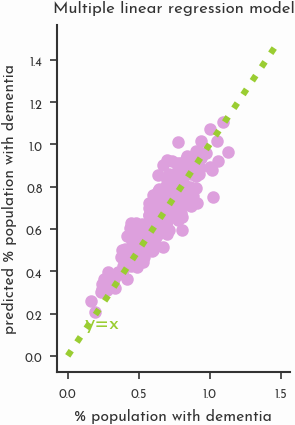

In [47]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 

plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='yellowgreen')
plt.scatter(y_test_all, y_pred_all_GP, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(0.12, 0.13, r'y=x', fontsize=10, color='yellowgreen')
#plt.text(0.2, 0.12, r'potential underdiagnosis', fontsize=10)
plt.show()

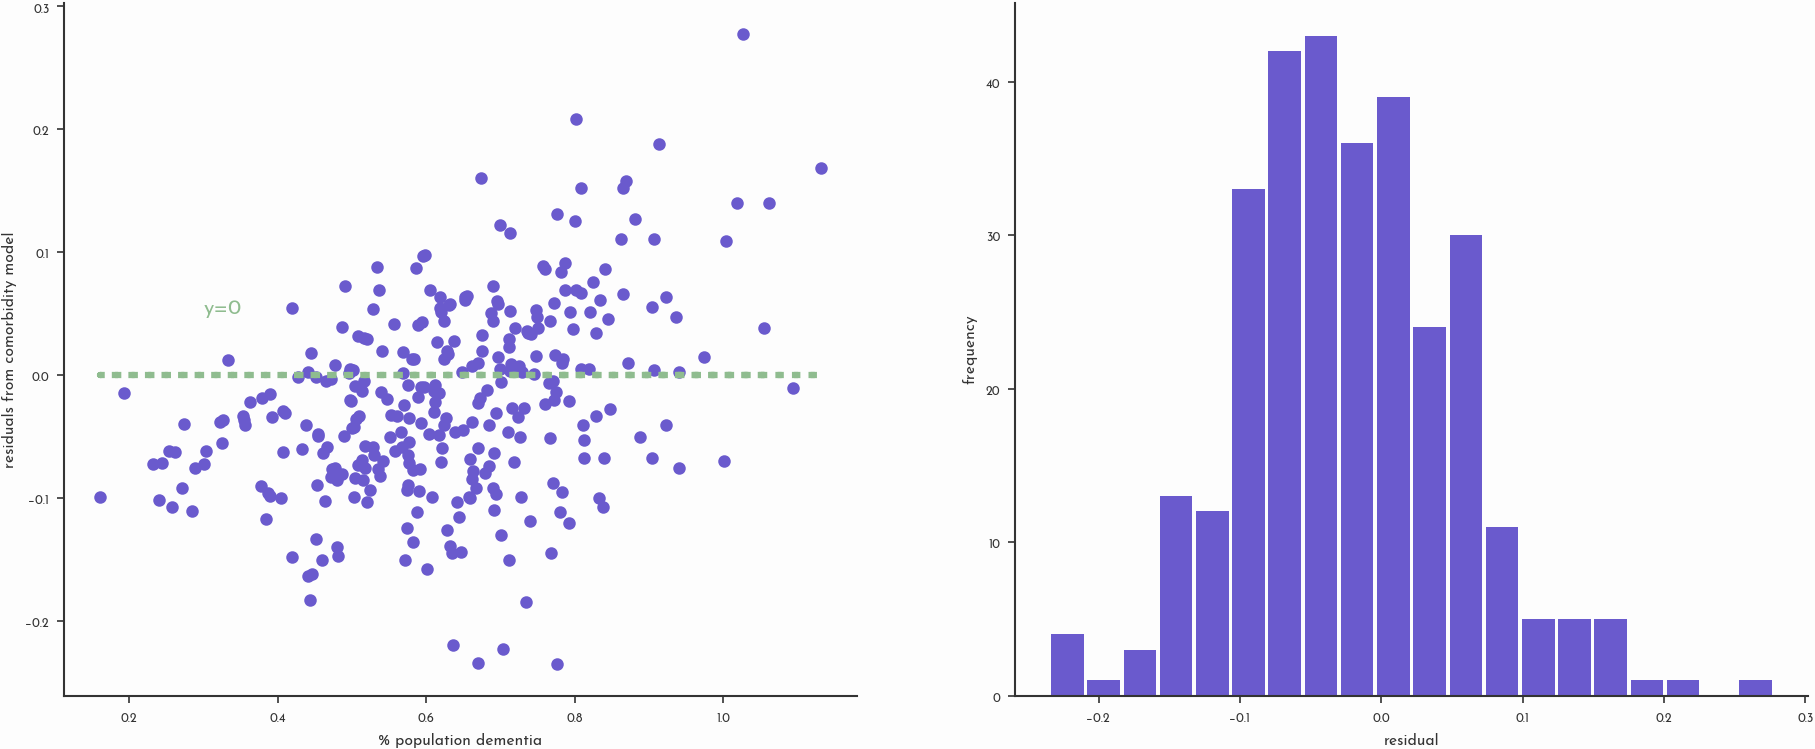

In [48]:
plt.subplots(nrows=1, ncols= 2, figsize = (15,6))

GP_residuals = (y_test_all-y_pred_all_GP)
 
# look at the residuals 
plt.subplot(1, 2, 1)
plt.scatter(y_test_all, GP_residuals, color='slateblue')
plt.plot(y_test_all, np.zeros(len(y_test_all)), ':', color='darkseagreen')
plt.text(0.3, 0.05, r'y=0', fontsize=10, color='darkseagreen')
plt.ylabel('residuals from comorbidity model')
plt.xlabel('% population dementia')

# histogram plot of the models residuals
plt.subplot(1, 2, 2)
plt.hist(GP_residuals, color='slateblue', rwidth=0.9, bins=20)
plt.xlabel('residual')
plt.ylabel('frequency')
plt.show()

In [49]:
# add columns of results to the dataframe 
df_dem_plus['GP_reg_model_residuals'] = GP_residuals
df_dem_plus['GP_reg_model_pred'] = y_pred_all_GP

# save the dataframe 
df_dem_plus.to_csv(const.output_path+'/test_set_reg_model/GP_reg_model_results.csv')